In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
import os

dataset_path = "/kaggle/input/ecg-analysis/ECG_DATA/train/"

if os.path.exists(dataset_path):
    print("Dataset path exists!")
    actual_classes = os.listdir(dataset_path)
    print("Folders found:", actual_classes)
else:
    print("Dataset path does NOT exist. Check the path!")


Dataset path exists!
Folders found: ['ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'Normal Person ECG Images (284x12=3408)', 'ECG Images of Myocardial Infarction Patients (240x12=2880)']


In [4]:
dataset_path = "/kaggle/input/ecg-analysis/ECG_DATA/train/"
classes = os.listdir(dataset_path)  # Automatically detect class names
print("Detected classes:", classes)


Detected classes: ['ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'Normal Person ECG Images (284x12=3408)', 'ECG Images of Myocardial Infarction Patients (240x12=2880)']


In [5]:
# Define image size
IMG_SIZE = (224, 224)

# Define dataset paths
dataset_path = "/kaggle/input/ecg-analysis/ECG_DATA/train/"
classes = ['ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'Normal Person ECG Images (284x12=3408)', 'ECG Images of Myocardial Infarction Patients (240x12=2880)']
# Initialize lists
images = []
labels = []

# Load images
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize
        images.append(img)
        labels.append(class_idx)

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (2418, 224, 224, 3), Test size: (605, 224, 224, 3)


In [6]:
# Load VGG16 model (excluding final classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Select the last convolutional layer for feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Extract feature maps
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Flatten feature maps to 1D vectors
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

print(f"Extracted feature shape: {X_train_features.shape}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 585s 8s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step
Extracted feature shape: (2418, 100352)


In [7]:
pca = PCA(n_components=100)  # Reduce dimensions to 100 components
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

print(f"Reduced feature shape: {X_train_pca.shape}")


Reduced feature shape: (2418, 100)


In [13]:
# Reduce feature dimensions using PCA
pca = PCA(n_components=300)  # Reduce dimensions to 300
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

print(f"PCA reduced feature shape: {X_train_pca.shape}")


PCA reduced feature shape: (2418, 300)


In [15]:
# Initialize a dictionary to store accuracy scores
train_accuracies = {}
test_accuracies = {}

# Train & Evaluate Classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_train)  # Train model
    
    # Training Accuracy
    y_train_pred = clf.predict(X_train_pca)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracies[name] = train_acc
    
    # Testing Accuracy
    y_test_pred = clf.predict(X_test_pca)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = test_acc
    
    print(f"\n{name} Training Accuracy: {train_acc:.4f}")
    print(f"{name} Testing Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))



kNN Training Accuracy: 0.9909
kNN Testing Accuracy: 0.9570
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       140
           1       0.94      0.96      0.95       103
           2       0.93      0.98      0.95       171
           3       1.00      1.00      1.00       191

    accuracy                           0.96       605
   macro avg       0.95      0.95      0.95       605
weighted avg       0.96      0.96      0.96       605


Decision Tree Training Accuracy: 0.8896
Decision Tree Testing Accuracy: 0.8694
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       140
           1       0.78      0.59      0.67       103
           2       0.77      0.96      0.85       171
           3       0.98      0.97      0.98       191

    accuracy                           0.87       605
   macro avg       0.86      0.84      0.84       605
weighted avg       0.87      0.87      0.87  

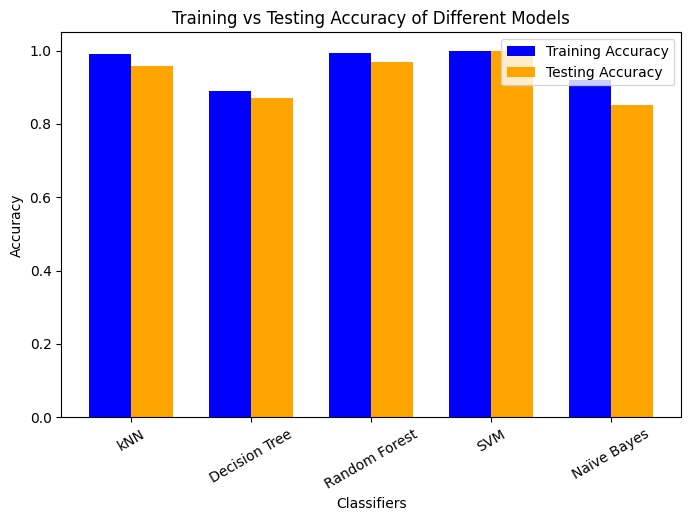

In [16]:
import matplotlib.pyplot as plt

# Plot Training vs Testing Accuracy
fig, ax = plt.subplots(figsize=(8,5))
x_labels = list(classifiers.keys())

# Bar width
bar_width = 0.35
x_indexes = np.arange(len(x_labels))

# Plot bars
plt.bar(x_indexes, list(train_accuracies.values()), width=bar_width, label="Training Accuracy", color='blue')
plt.bar(x_indexes + bar_width, list(test_accuracies.values()), width=bar_width, label="Testing Accuracy", color='orange')

# Labels & Legends
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy of Different Models")
plt.xticks(ticks=x_indexes + bar_width/2, labels=x_labels, rotation=30)
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Initialize dictionaries to store accuracy scores
train_accuracies = {}
test_accuracies = {}
cv_accuracies = {}

# Train & Evaluate Classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_train)  # Train model
    
    # Cross-validation Accuracy
    cv_acc = cross_val_score(clf, X_train_pca, y_train, cv=5).mean()
    cv_accuracies[name] = cv_acc

    # Training Accuracy
    y_train_pred = clf.predict(X_train_pca)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracies[name] = train_acc
    
    # Testing Accuracy
    y_test_pred = clf.predict(X_test_pca)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = test_acc
    
    # Print results
    print(f"\n{name} Cross-Validation Accuracy: {cv_acc:.4f}")
    print(f"{name} Training Accuracy: {train_acc:.4f}")
    print(f"{name} Testing Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))



kNN Cross-Validation Accuracy: 0.9227
kNN Training Accuracy: 0.9909
kNN Testing Accuracy: 0.9570
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       140
           1       0.94      0.96      0.95       103
           2       0.93      0.98      0.95       171
           3       1.00      1.00      1.00       191

    accuracy                           0.96       605
   macro avg       0.95      0.95      0.95       605
weighted avg       0.96      0.96      0.96       605


Decision Tree Cross-Validation Accuracy: 0.8586
Decision Tree Training Accuracy: 0.8896
Decision Tree Testing Accuracy: 0.8694
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       140
           1       0.78      0.59      0.67       103
           2       0.77      0.96      0.85       171
           3       0.98      0.97      0.98       191

    accuracy                           0.87       605
   macro avg 


kNN Cross-Validation Accuracy: 0.9227
kNN Training Accuracy: 0.9909
kNN Testing Accuracy: 0.9570
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       140
           1       0.94      0.96      0.95       103
           2       0.93      0.98      0.95       171
           3       1.00      1.00      1.00       191

    accuracy                           0.96       605
   macro avg       0.95      0.95      0.95       605
weighted avg       0.96      0.96      0.96       605



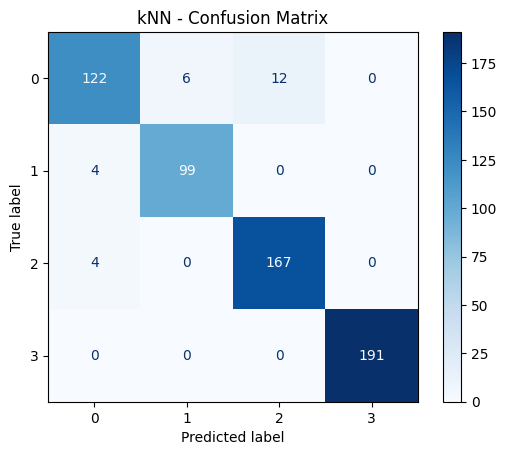


Decision Tree Cross-Validation Accuracy: 0.8577
Decision Tree Training Accuracy: 0.8896
Decision Tree Testing Accuracy: 0.8694
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       140
           1       0.78      0.59      0.67       103
           2       0.77      0.96      0.85       171
           3       0.98      0.97      0.98       191

    accuracy                           0.87       605
   macro avg       0.86      0.84      0.84       605
weighted avg       0.87      0.87      0.87       605



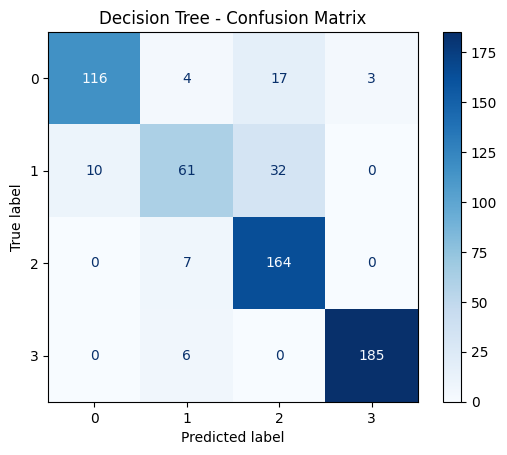


Random Forest Cross-Validation Accuracy: 0.9719
Random Forest Training Accuracy: 0.9938
Random Forest Testing Accuracy: 0.9702
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       140
           1       1.00      0.87      0.93       103
           2       0.92      1.00      0.96       171
           3       1.00      1.00      1.00       191

    accuracy                           0.97       605
   macro avg       0.97      0.96      0.97       605
weighted avg       0.97      0.97      0.97       605



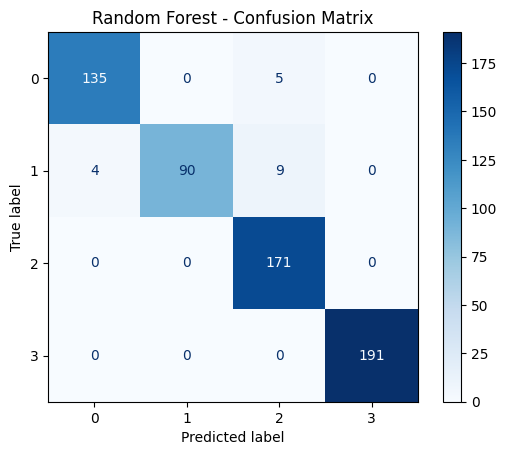


SVM Cross-Validation Accuracy: 0.9926
SVM Training Accuracy: 1.0000
SVM Testing Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       103
           2       1.00      1.00      1.00       171
           3       1.00      1.00      1.00       191

    accuracy                           1.00       605
   macro avg       1.00      1.00      1.00       605
weighted avg       1.00      1.00      1.00       605



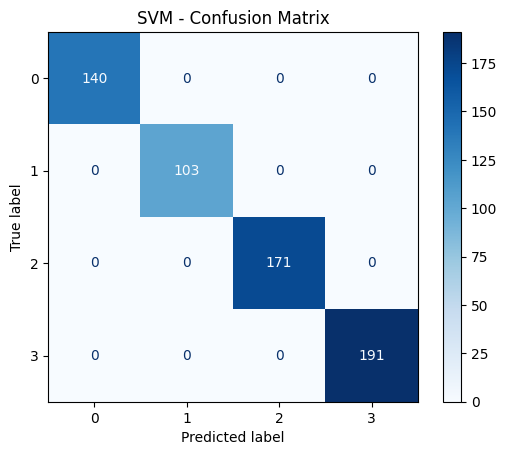


Naïve Bayes Cross-Validation Accuracy: 0.8937
Naïve Bayes Training Accuracy: 0.9202
Naïve Bayes Testing Accuracy: 0.8529
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       140
           1       0.95      0.70      0.80       103
           2       0.75      0.91      0.82       171
           3       1.00      1.00      1.00       191

    accuracy                           0.85       605
   macro avg       0.86      0.83      0.84       605
weighted avg       0.86      0.85      0.85       605



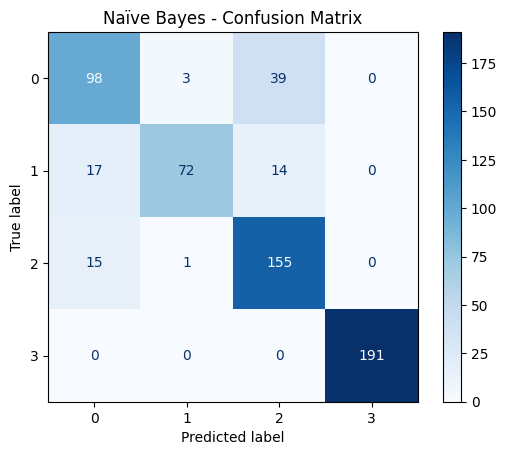

<Figure size 1000x600 with 0 Axes>

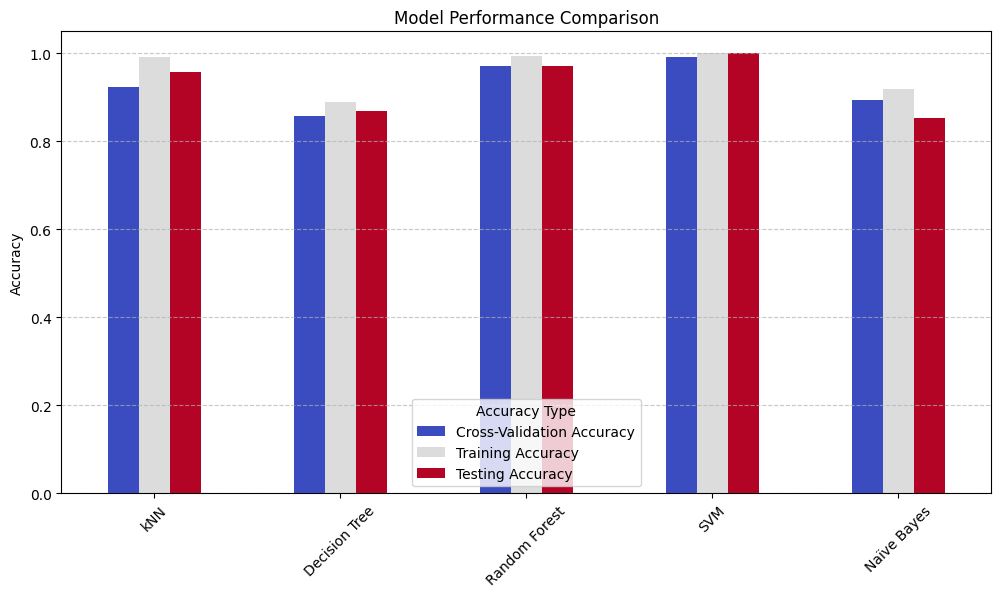

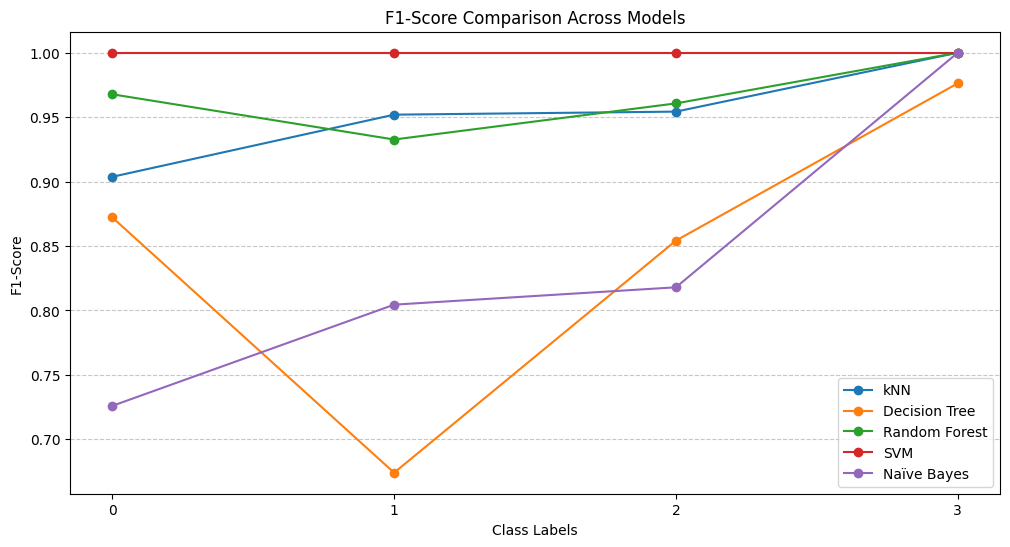

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Initialize dictionaries to store accuracy scores
train_accuracies = {}
test_accuracies = {}
cv_accuracies = {}

# Store classification reports
classification_reports = {}

# Train & Evaluate Classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_train)  # Train model
    
    # Cross-validation Accuracy
    cv_acc = cross_val_score(clf, X_train_pca, y_train, cv=5).mean()
    cv_accuracies[name] = cv_acc

    # Training Accuracy
    y_train_pred = clf.predict(X_train_pca)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracies[name] = train_acc
    
    # Testing Accuracy
    y_test_pred = clf.predict(X_test_pca)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies[name] = test_acc

    # Store classification report
    classification_reports[name] = classification_report(y_test, y_test_pred, output_dict=True)

    # Print results
    print(f"\n{name} Cross-Validation Accuracy: {cv_acc:.4f}")
    print(f"{name} Training Accuracy: {train_acc:.4f}")
    print(f"{name} Testing Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test_pca, y_test, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame({
    "Cross-Validation Accuracy": cv_accuracies,
    "Training Accuracy": train_accuracies,
    "Testing Accuracy": test_accuracies
})

# Plot Accuracies
plt.figure(figsize=(10, 6))
results_df.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Accuracy Type")
plt.show()

# Plot Precision, Recall, F1-score for each model
plt.figure(figsize=(12, 6))
for name, report in classification_reports.items():
    scores = [report[str(label)]["f1-score"] for label in np.unique(y_test)]
    plt.plot(np.unique(y_test), scores, marker="o", label=name)

plt.title("F1-Score Comparison Across Models")
plt.xlabel("Class Labels")
plt.ylabel("F1-Score")
plt.xticks(np.unique(y_test))
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# 

# NNDL LAB07

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os


In [25]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_path = "/kaggle/input/ecg-analysis/ECG_DATA/train/"
test_path = "/kaggle/input/ecg-analysis/ECG_DATA/test/"

datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)


Found 3023 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Class Names: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


In [26]:
# Load pretrained EfficientNetB0 (without top layer)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Add a custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')  # 4 classes
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,410,919 (16.83 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
EPOCHS = 20

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.3020 - loss: 1.3680 - val_accuracy: 0.2575 - val_loss: 1.3792 - learning_rate: 0.0010
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.3138 - loss: 1.3664 - val_accuracy: 0.2575 - val_loss: 1.3800 - learning_rate: 0.0010
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.3242 - loss: 1.3676 - val_accuracy: 0.2575 - val_loss: 1.3743 - learning_rate: 0.0010
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.3220 - loss: 1.3594 - val_accuracy: 0.2575 - val_loss: 1.3750 - learning_rate: 0.0010
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3082 - loss: 1.3651 - val_accuracy: 0.2575 - val_loss: 1.3770 - learning_rate: 0.0010
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.3226 - loss: 1.3586 - val_accuracy: 0.2575 - val_loss: 1.3760 - learning_rate: 0.0010
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.3173 - loss: 1.3625 - val_acc

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [29]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_path = "/kaggle/input/ecg-analysis/ECG_DATA/train/"
test_path = "/kaggle/input/ecg-analysis/ECG_DATA/test/"

# Data augmentation + Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)


Found 3023 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Class Names: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


In [32]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

model = models.Sequential([
    base_model,
    layers.BatchNormalization(),  # Batch Normalization
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 Regularization
    layers.Dropout(0.4),  # Dropout to prevent overfitting
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,416,039 (16.85 MB)

 Trainable params: 363,908 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

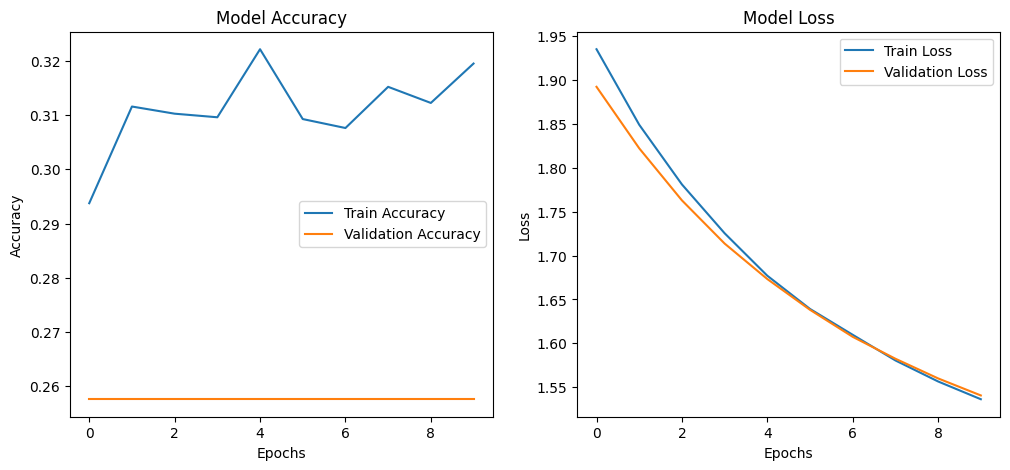

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


In [39]:
# Get test loss & accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Predict test labels
y_true = test_generator.classes  # Actual labels
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted labels

# Compute precision, recall, F1-score
class_names = list(test_generator.class_indices.keys())
classification_metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Display classification report
print("\n📌 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Extract precision, recall, F1-score for each class
for class_label in class_names:
    precision = classification_metrics[class_label]["precision"]
    recall = classification_metrics[class_label]["recall"]
    f1_score = classification_metrics[class_label]["f1-score"]
    print(f"\nClass: {class_label}")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"🔁 Recall: {recall:.4f}")
    print(f"⚡ F1-Score: {f1_score:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5827 - loss: 1.4989

✅ Test Loss: 1.5405
✅ Test Accuracy: 0.2575
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step

📌 Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.26      1.00      0.41       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.00      0.00      0.00       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.00      0.00      0.00       233
                          Normal Person ECG Images (284x12=3408)       0.00      0.00      0.00       284

                                                        accuracy                           0.26       928
                                                       macro avg       0.06      0.25      0.10       928
                                                    weighted avg       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [33]:
EPOCHS = 10

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.2793 - loss: 1.9583 - val_accuracy: 0.2575 - val_loss: 1.8925 - learning_rate: 1.0000e-04
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3120 - loss: 1.8650 - val_accuracy: 0.2575 - val_loss: 1.8223 - learning_rate: 1.0000e-04
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3042 - loss: 1.7996 - val_accuracy: 0.2575 - val_loss: 1.7630 - learning_rate: 1.0000e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3119 - loss: 1.7404 - val_accuracy: 0.2575 - val_loss: 1.7137 - learning_rate: 1.0000e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3282 - loss: 1.6845 - val_accuracy: 0.2575 - val_loss: 1.6732 - learning_rate: 1.0000e-04
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.3232 - loss: 1.6460 - val_accuracy: 0.2575 - val_loss: 1.6381 - learning_rate: 1.0000e-04
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.3112 

#  **LAB08**

In [34]:
# Dropout Regularization (0.4)
dropout_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

dropout_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


In [35]:
# Batch Normalization
batchnorm_model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax')
])

batchnorm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


In [36]:
# L2 Regularization (Weight Decay)
l2_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(len(class_names), activation='softmax')
])

l2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


In [40]:
# 
EPOCHS = 10
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

models_dict = {
    
    "Dropout": dropout_model,
    "BatchNorm": batchnorm_model,
    "L2 Regularization": l2_model
}

results = {}

for name, model in models_dict.items():
    print(f"\nTraining {name} Model...")
    history = model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS, callbacks=callbacks)

    # Evaluate performance
    test_loss, test_acc = model.evaluate(test_generator)
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)

    # Store results
    results[name] = {
        "history": history,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "classification_report": classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    }

    print(f"{name} Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))



Training Dropout Model...
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.3014 - loss: 1.3734 - val_accuracy: 0.2575 - val_loss: 1.3774 - learning_rate: 1.0000e-04
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3161 - loss: 1.3639 - val_accuracy: 0.2575 - val_loss: 1.3775 - learning_rate: 1.0000e-04
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3280 - loss: 1.3530 - val_accuracy: 0.2575 - val_loss: 1.3792 - learning_rate: 1.0000e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3182 - loss: 1.3648 - val_accuracy: 0.2575 - val_loss: 1.3785 - learning_rate: 1.0000e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3195 - loss: 1.3636 - val_accuracy: 0.2575 - val_loss: 1.3791 - learning_rate: 2.0000e-05
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3310 - loss: 1.3590 - val_accuracy: 0.2575 - val_loss: 1.3785 - learning_rate: 2.0000e-05
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.2607 - loss: 1.4639 - val_accuracy: 0.3060 - val_loss: 1.3804 - learning_rate: 1.0000e-04
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.2742 - loss: 1.4137 - val_accuracy: 0.2575 - val_loss: 1.3767 - learning_rate: 1.0000e-04
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.2913 - loss: 1.4187 - val_accuracy: 0.2575 - val_loss: 1.3787 - learning_rate: 1.0000e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3054 - loss: 1.3953 - val_accuracy: 0.2575 - val_loss: 1.3836 - learning_rate: 1.0000e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.2983 - loss: 1.3870 - val_accuracy: 0.2575 - val_loss: 1.3897 - learning_rate: 1.0000e-04
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.2932 - loss: 1.3803 - val_accuracy: 0.2575 - val_loss: 1.4102 - learning_rate: 2.0000e-05
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.3101 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.3178 - loss: 1.7727 - val_accuracy: 0.3060 - val_loss: 1.7171 - learning_rate: 1.0000e-04
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.2948 - loss: 1.6897 - val_accuracy: 0.2575 - val_loss: 1.6586 - learning_rate: 1.0000e-04
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.3021 - loss: 1.6286 - val_accuracy: 0.2575 - val_loss: 1.6096 - learning_rate: 1.0000e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3156 - loss: 1.5772 - val_accuracy: 0.2575 - val_loss: 1.5652 - learning_rate: 1.0000e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3029 - loss: 1.5467 - val_accuracy: 0.2575 - val_loss: 1.5452 - learning_rate: 1.0000e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.0661 - loss: 1.7030
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
L2 Regularization Test Accuracy: 0.3060
                                                                  precisi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

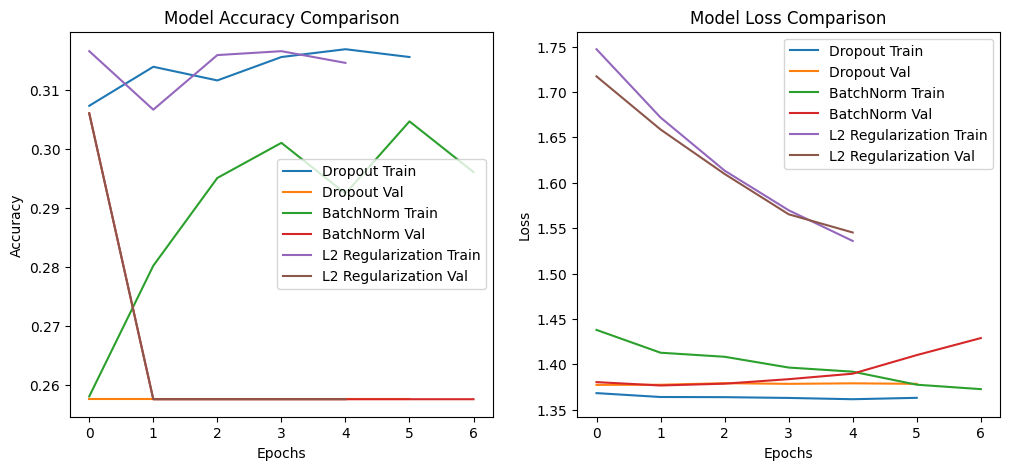

In [41]:
plt.figure(figsize=(12, 5))

for name, result in results.items():
    history = result["history"]

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"{name} Train")
    plt.plot(history.history['val_accuracy'], label=f"{name} Val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy Comparison")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"{name} Train")
    plt.plot(history.history['val_loss'], label=f"{name} Val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss Comparison")

plt.show()


# **LAB09**

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [44]:
# Define image size & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Apply Data Augmentation & Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

# Load Data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/ecg-analysis/ECG_DATA/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Ensures one-hot encoding
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/ecg-analysis/ECG_DATA/test/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Ensures one-hot encoding
)


Found 3023 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


In [45]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),  # Regularization to prevent overfitting
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')  # 4 classes
    ])
    return model

model = build_model()


In [ ]:
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001)
}

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name} Optimizer...\n")

    model = build_model()  # Reinitialize model for each optimizer
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
    ]

    # Train Model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        callbacks=callbacks
    )

    # Evaluate Model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{opt_name} Test Accuracy: {test_acc:.4f}")

    # Predictions
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes

    # Classification Report
    print(classification_report(y_true, y_pred))



Training with Adam Optimizer...

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.2712 - loss: 20.3212 - val_accuracy: 0.2575 - val_loss: 22.6563 - learning_rate: 0.0010
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.2848 - loss: 1.6307 - val_accuracy: 0.2425 - val_loss: 22.1360 - learning_rate: 0.0010
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.3089 - loss: 1.3808 - val_accuracy: 0.2845 - val_loss: 2.8965 - learning_rate: 0.0010
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.3083 - loss: 1.4004 - val_accuracy: 0.2565 - val_loss: 6.3893 - learning_rate: 0.0010
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.3137 - loss: 1.3709 - val_accuracy: 0.2532 - val_loss: 3.8392 - learning_rate: 0.0010
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.3226 - loss: 1.3603 - val_accuracy: 0.2575 - val_loss: 1.3772 - learning_rate: 0.0010
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.3243 - loss: 1.3648 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolu

Epoch 1/10
12/95 ━━━━━━━━━━━━━━━━━━━━ 4:20 3s/step - accuracy: 0.2692 - loss: 18.8460

In [1]:
def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")

    plt.show()

plot_training(history)


NameError: name 'history' is not defined